# Libraries

In [1]:
'''Math & Data Libraries'''
import numpy as np # Library for numerical processing 
import pandas as pd # Library for data organization
import glob # Library for file management

'''Visualization & Image Libraries'''
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.colors import ListedColormap
from PIL import Image

'''Image Processing Libraries'''
import cv2

cmap = ListedColormap(['w', 'y', 'g']) # Colormap used to visualize leaves

## Functions

In [2]:
def calculate_position(contour, position_weights = [1, 0]):
    """
    Calculate position of leaf. Used to sort leaves based on their position in the image.
    ---
    Arguments:
    contour : np.array of dimension (n, 1, 2) where n is the amount of segments needed to create the contour
        The leaf contour for which the position needs to be calculated.
    position_weights : list of 2 elements. Default = [1, 0]
        The weight of the x (up-down) and y (left-right) axes used in the calculation. By default, the weight of the vertical (x axis) is 
        zero in order to give priority to left-right than to up down. If you want to achieve a typical left-right up-down traversal then 
        we can use a weight such as [2, 1]
    Returns:
        Coefficient calculated from the top-left position in the contour weighted by the position_weights argument.
    """
    return np.mean(np.min(contour.reshape(-1,2), axis = 0)*position_weights) #We first calculate the minimum values (top-left position) of the contour, multiply them by the position_weights argument and return the mean

def preprocess_leaf(image_paths, threshold = None, leaf_size_threshold = 6, scan_size = (420, 297), resize_image = True, image_resolution_width = 1024, visualize_images = True, save_images = False, visualize_histogram = False, position_weights = [1, 0]):
    """
    Go over all leaves in the image and calculate the leaf area, holes area and leaf height and width.
    ---
    Arguments:
    image_paths : list of strings
        A list that contains the image file locations for which the calculations should be done.
    threshold : int or None. Default None
        A value between 0 and 255, used to get the initial labeling of background and foreground. If set to None, threshold will be automatically chosen using Otsu's method.  
    leaf_size_threshold : float. Default 6
        The minimum value in cm of the height or width of the leaf 
    scan_size : tuple of two numbers. Default = (420, 297)
        The size in milimeters of the height and width of the scanned image. The default is an A3 format so its set to 420mm x 297mm 
    resize_image : boolean. Default = True
        Whether to resize the image to a lower resolution in order to lower computation time.
    image_resolution_width : int
        The width (number of pixels) of the resized image. The height will by scaled proportionally. Only works if resize_image = True. 
    visualize_images : boolean. Default = True
        Whether to visualize each leaf contour
    save_images : boolean. Default = False
        Whether to save each leaf contour 
    visualize_histogram : boolean. Default = False
        Whether to visualize the histogram of the image along with the automatically discovered threshold. Can be utilized to find a value for a manual threshold of the image. 
    position_weights : list of 2 elements. Default = [1, 0]
        The weight of the x (up-down) and y (left-right) axes used in the calculation. By default, the weight of the vertical (x axis) is 
        zero in order to give priority to left-right than to up down. If you want to achieve a typical left-right up-down traversal then 
        we can use a weight such as [2, 1]
    Returns:
        Coefficient calculated from the top-left position in the contour weighted by the position_weights argument.
    """
    result_list = [] # We initialize a list that will contain the results
    for image_path in image_paths:
        file_name = image_path.split("\\")[-1][:-4] # Get the filename
        print(file_name)
        image = Image.open(image_path) # Open the image from the given image_path 
        if(type(image) != np.ndarray):
            image = np.array(image, np.uint8)[:,:,:3] # Since we open the image with the PIL library we need to transform it to a numpy array
        if(resize_image): # If the resize_image argument is set to True we resize the image to the designated resolution
            width = image_resolution_width # We take the width provided as input
            height = int(image.shape[0]/image.shape[1]*width) # We calculate the proportional height based on the required width 
            dim = (width, height) 
            # print(dim)
            image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) # We use the openCV resize function to resize the image
        img_grayscale = np.min(image, axis=2).astype(np.uint8) # We first transform the image from 3D to 2D. 
        #The simplest way this can be done is by taking its mean and getting a grayscale representation of the image. However, since the background is usually 
        # white and therefore has the highest values across all bands, in this case we take the minimum value across the three channels which should low for leafs while high for the white background

        # We then threshold this grayscale image to black and white values which result in our initial estimate of the foreground (leaves) and background
        if(threshold is not None): 
            # If the threshold is given as an argument, then we use to split the grayscale image into black and white which are then set as probable foreground and background
            mask = np.zeros(image.shape[:-1], np.uint8)
            mask[img_grayscale < threshold] = cv2.GC_PR_FGD
            mask[img_grayscale >= threshold] = cv2.GC_BGD
        else: 
            threshold, mask = cv2.threshold(img_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # If the threshold is not set, the otsu method is used to find it automatically and again the probable foreground and background are set 
            mask[mask==0] = cv2.GC_PR_FGD
            mask[mask==255] = cv2.GC_BGD

        if(visualize_histogram):
            plt.figure(figsize = (10,4))
            plt.title(f"{file_name} Histogram")
            sns.kdeplot(img_grayscale.flatten(), color = "blue", label = "Histogram")
            plt.axvline(x = threshold, color = "orange", label = f'Threshold = {threshold}')
            plt.legend()
            plt.show()    
            
        threshold = None

        # We now use the grabCut algorithm to get the final foreground estimate using the image and initial estimates from the threshold
        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")
        (mask, bgModel, fgModel) = cv2.grabCut(image, mask, None, bgModel,
            fgModel, iterCount=10, mode=cv2.GC_INIT_WITH_MASK)

        valueMask = (mask == 0).astype("uint8") * 255 # Once we have the mask we transform it to the format required by the findContours
        valueMask_orig = valueMask.copy() # We keep the original mask as a copy 
        des = cv2.bitwise_not(valueMask) # In order to find the contours, we first create a bitwise NOT of the mask (so all black values turn white and vice versa) 
        contour, hier = cv2.findContours(des, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # We use the openCV function findContours which returns a list of all found contours
        for cnt in contour: # We loop over all contours and draw them on the mask. This will help us fill the holes within the leaves
            cv2.drawContours(des, [cnt], 0, 255, -1)
        valueMask = cv2.bitwise_not(des) # Finally we do a bitwise NOT of the result to get the final mask

        # We do the findContours process again with the cv2.RETR_EXTERNAL flag to only get the external contours of the image which should represent the leaves 
        des = cv2.bitwise_not(valueMask)
        contour, hier = cv2.findContours(des, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contour:
            cv2.drawContours(des,[cnt],0,255,-1)
        valueMask = cv2.bitwise_not(des)

        contour = list(contour) # We transform the contour to a list 
        contour.sort(key = lambda x: calculate_position(x, position_weights)) # And then sort it based on the position of the contours. This can be changed to other functions such as the contour size
        
        img_pixels = image.shape[0] * image.shape[1] # Calculate the total number of pixels in the image 

        leaf_i = 0
        for i in range(len(contour)): # Finally we loop over all contours in order to get the results

            mask = np.zeros_like(valueMask) # We create an empty mask on which the contours will be drawn

            min_cnt = np.min(contour[i].reshape(-1,2), axis = 0) # We calculate the minimum and maximum span of the contours
            max_cnt = np.max(contour[i].reshape(-1,2), axis = 0)

            height = (max_cnt[1]-min_cnt[1])/image.shape[0] * scan_size[0]/10 # We calculate the height and width of the contour in cm
            width = (max_cnt[0]-min_cnt[0])/image.shape[1] * scan_size[1]/10

            # print(height, width, np.abs(height-width))
            if(height<leaf_size_threshold and width<leaf_size_threshold): # If the height and width are less than 6 cm then go on to the next contour
                continue
            if(np.abs(height-width)<0.3):
                continue
            
            cv2.drawContours(mask, [contour[i]], 0, 255, thickness=cv2.FILLED)  # Draw the selected contour on the empty mask
                        
            mask_sub = mask[min_cnt[1]:max_cnt[1], min_cnt[0]:max_cnt[0]] - ~valueMask_orig[min_cnt[1]:max_cnt[1], min_cnt[0]:max_cnt[0]] # We subtract the original mask from the contour mask in order to get the holes within the contour, only for the part of the image where the contour spans
            mask_sub = np.where(mask_sub<2, 0 , 255)
            
            if(visualize_images): # If the visualize_images flag is set to True, we visualize the images
                plt.figure()
                plt.title(f"{file_name}_Leaf_{leaf_i+1}")
                plt.imshow((mask[min_cnt[1]:max_cnt[1], min_cnt[0]:max_cnt[0]]-mask_sub*0.5)/127.5, cmap = cmap) # We visualize the result divided as the background, holes and leaves.
                plt.show()

            if(save_images): # If the save_images flag is set to True, we save the images in the Data/Result Images folder
                plt.figure()
                plt.title(f"{file_name}_Leaf_{leaf_i+1}")
                plt.imshow((mask[min_cnt[1]:max_cnt[1], min_cnt[0]:max_cnt[0]]-mask_sub*0.5)/127.5, cmap = cmap) 
                plt.savefig(f'../Data/Result Images/{file_name}_Leaf_{leaf_i+1}_processed.png')

            total_size = np.sum(mask==255)*scan_size[1]/img_pixels*scan_size[0]/100
            holes_size = np.sum(mask_sub==255)*scan_size[1]/img_pixels*scan_size[0]/100

            result_array = [file_name, leaf_i+1, total_size, total_size-holes_size, holes_size, height, width] # We add these results for each leaf into a list and then append it to the result list
            result_list.append(result_array) 
            leaf_i += 1
        print("\n\n\n")    
    df = pd.DataFrame(result_list, columns = ["FileName", "Leaf#", "Total Leaf Size (cm2)", "Leaf Full Size (cm2) ", "Leaf Empty Size (cm2)", "Leaf Height", "Leaf Width"])
    return df

# Input Data

In [3]:
image_folder = "../Data/Leaf Images/" # Location of folder that contains the images
image_paths_all = glob.glob(image_folder+"*_ed.jpg")
image_paths = glob.glob(image_folder+"*_ed.jpg")[1:2]

In [4]:
image_paths_all

['../Data/Leaf Images\\BJ4-3792-lf-00_ed.jpg',
 '../Data/Leaf Images\\BJ4-3800-lf-01_ed.jpg',
 '../Data/Leaf Images\\BJ4-3821-lf-d1_ed.jpg',
 '../Data/Leaf Images\\BO4-3916-lf-01_ed.jpg',
 '../Data/Leaf Images\\R11-4066-lf-00_ed.jpg',
 '../Data/Leaf Images\\S06-1576-lf-02_ed.jpg',
 '../Data/Leaf Images\\S19-1039-lf-02_ed.jpg',
 '../Data/Leaf Images\\S23-0744-lf-02_ed.jpg',
 '../Data/Leaf Images\\S25-1708-lf-04_ed.jpg',
 '../Data/Leaf Images\\S25-1736-lf-02_ed.jpg']

# Leaf Area Extraction

## Simplest Usage

BJ4-3800-lf-01_ed


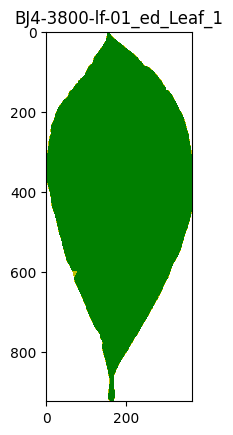

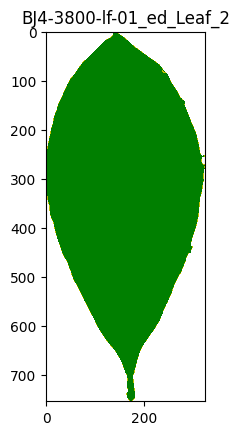

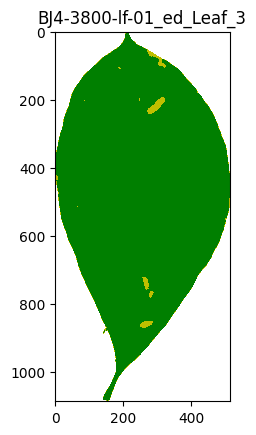

In [5]:
df_results = preprocess_leaf(image_paths)

In [6]:
df_results

,FileName,Leaf#,Total Leaf Size (cm2),Leaf Full Size (cm2),Leaf Empty Size (cm2),Leaf Height,Leaf Width
0,BJ4-3800-lf-01_ed,1,167.292288,167.208161,0.084127,26.801105,10.615430
1,BJ4-3800-lf-01_ed,2,124.113083,124.085321,0.027762,21.870166,9.426270
2,BJ4-3800-lf-01_ed,3,281.417772,278.449759,2.968013,31.529006,14.908008


## Usage with Resized Images 

BJ4-3800-lf-01_ed


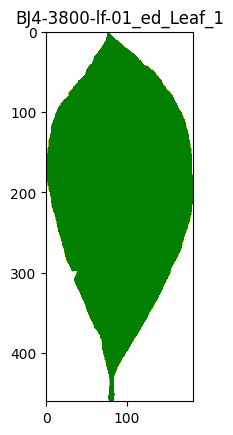

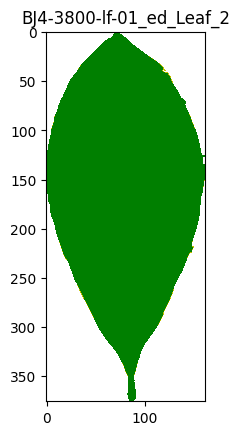

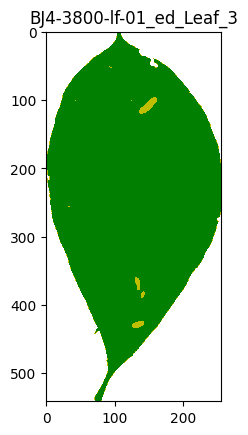

In [7]:
df_results = preprocess_leaf(image_paths, resize_image = True, image_resolution_width = 512)

In [8]:
df_results

,FileName,Leaf#,Total Leaf Size (cm2),Leaf Full Size (cm2),Leaf Empty Size (cm2),Leaf Height,Leaf Width
0,BJ4-3800-lf-01_ed,1,167.309113,167.309113,0.000000,26.743094,10.615430
1,BJ4-3800-lf-01_ed,2,124.266195,124.266195,0.000000,21.812155,9.397266
2,BJ4-3800-lf-01_ed,3,280.780086,278.562489,2.217597,31.441989,14.908008


## Save Resulting Images

BJ4-3800-lf-01_ed






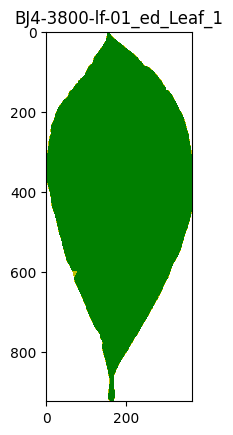

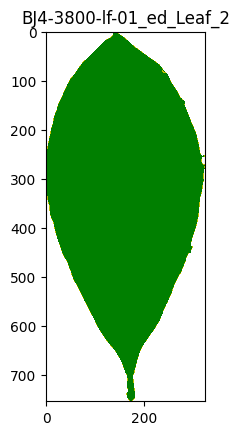

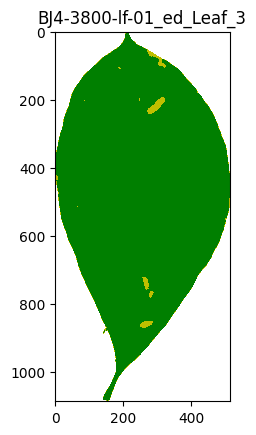

In [9]:
df_results = preprocess_leaf(image_paths, visualize_images = False, save_images = True)

## Adjust Threshold

BJ4-3800-lf-01_ed


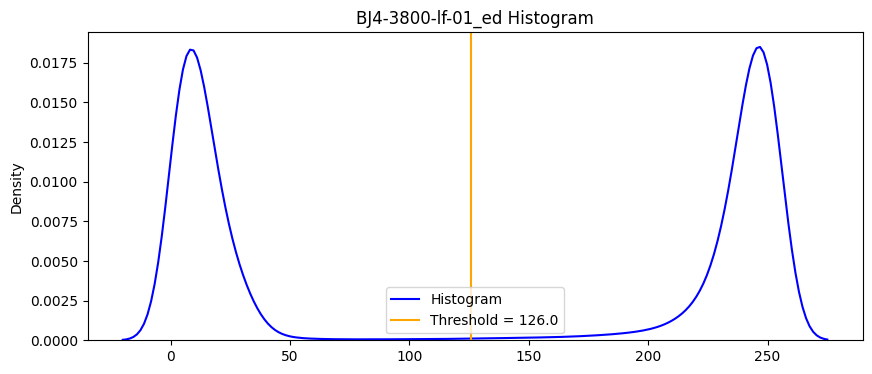

In [10]:
df_results = preprocess_leaf(image_paths, visualize_histogram = True, visualize_images = False)

In [11]:
df_results

,FileName,Leaf#,Total Leaf Size (cm2),Leaf Full Size (cm2),Leaf Empty Size (cm2),Leaf Height,Leaf Width
0,BJ4-3800-lf-01_ed,1,167.292288,167.208161,0.084127,26.801105,10.615430
1,BJ4-3800-lf-01_ed,2,124.113083,124.085321,0.027762,21.870166,9.426270
2,BJ4-3800-lf-01_ed,3,281.417772,278.449759,2.968013,31.529006,14.908008


BJ4-3800-lf-01_ed


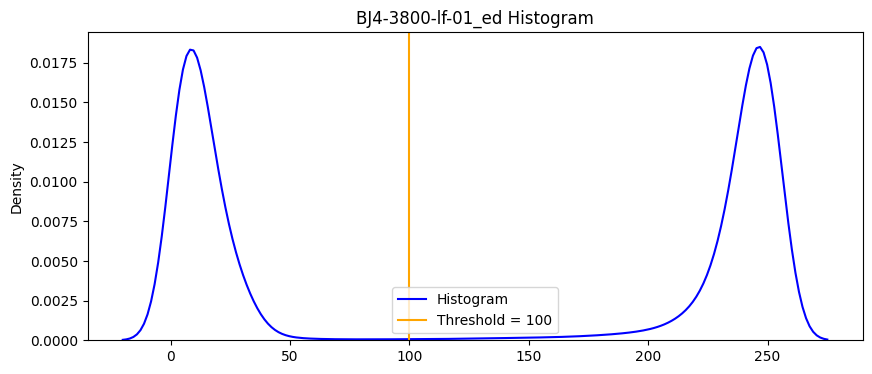

In [12]:
df_results = preprocess_leaf(image_paths, threshold = 100, visualize_histogram = True, visualize_images = False)

In [13]:
df_results

,FileName,Leaf#,Total Leaf Size (cm2),Leaf Full Size (cm2),Leaf Empty Size (cm2),Leaf Height,Leaf Width
0,BJ4-3800-lf-01_ed,1,166.538507,166.538507,0.000000,26.772099,10.615430
1,BJ4-3800-lf-01_ed,2,123.588970,123.555319,0.033651,21.812155,9.252246
2,BJ4-3800-lf-01_ed,3,279.886654,277.446961,2.439693,31.441989,14.908008


## Usage on entire data

In [14]:
df_results = preprocess_leaf(image_paths_all, leaf_size_threshold = 4, resize_image = True, image_resolution_width = 1024, visualize_images = False)

BJ4-3792-lf-00_ed




BJ4-3800-lf-01_ed




BJ4-3821-lf-d1_ed




BO4-3916-lf-01_ed




R11-4066-lf-00_ed




S06-1576-lf-02_ed




S19-1039-lf-02_ed




S23-0744-lf-02_ed




S25-1708-lf-04_ed




S25-1736-lf-02_ed






In [15]:
df_results

,FileName,Leaf#,Total Leaf Size (cm2),Leaf Full Size (cm2),Leaf Empty Size (cm2),Leaf Height,Leaf Width
0,BJ4-3792-lf-00_ed,1,27.725852,27.336342,0.389510,15.285912,3.219434
1,BJ4-3792-lf-00_ed,2,20.160279,20.155231,0.005048,13.110497,2.523340
2,BJ4-3792-lf-00_ed,3,58.264922,58.227064,0.037857,19.984807,5.249707
3,BJ4-3792-lf-00_ed,4,46.845475,45.427088,1.418387,20.941989,4.234570
4,BJ4-3792-lf-00_ed,5,75.871094,75.358758,0.512336,24.857735,5.742773
5,BJ4-3792-lf-00_ed,6,47.515129,45.955408,1.559721,21.203039,4.553613
6,BJ4-3792-lf-00_ed,7,78.215723,77.614213,0.601511,24.161602,5.249707
7,BJ4-3792-lf-00_ed,8,53.224011,51.910783,1.313228,20.796961,4.901660
8,BJ4-3792-lf-00_ed,9,100.224280,100.058549,0.165731,27.526243,6.351855
9,BJ4-3792-lf-00_ed,10,29.560669,28.840539,0.720130,15.459945,3.393457


In [16]:
df_results.to_csv("../Data/Leaf_Measurements_v1.csv", index = False)

When visualizing the results of scan S23-0744-lf-02_ed we can see that the manually painted outline is not covered in the initial threshold of 123 so we can manually check and increase it to 170 to account for this. In cases like this, we want to only run the function for the scans individually, otherwise this threshold will also transfer to the other images.

S23-0744-lf-02_ed


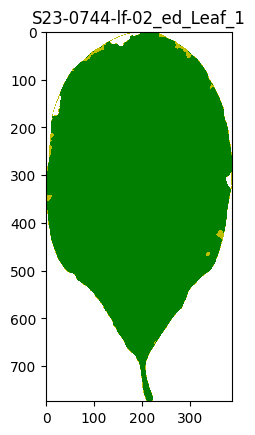

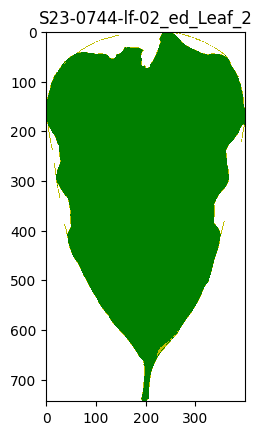

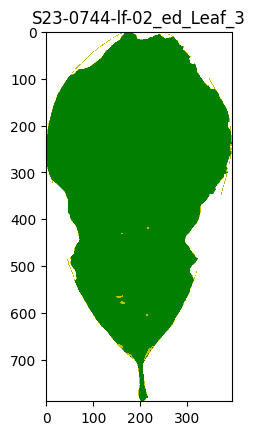

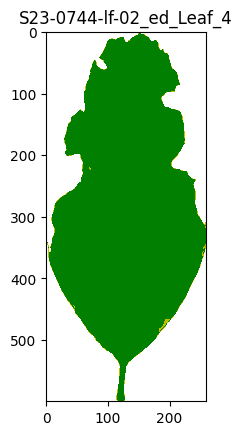

In [17]:
df_results = preprocess_leaf(image_paths_all[7: 8], resize_image = True, image_resolution_width = 1024, visualize_images = True)


S23-0744-lf-02_ed


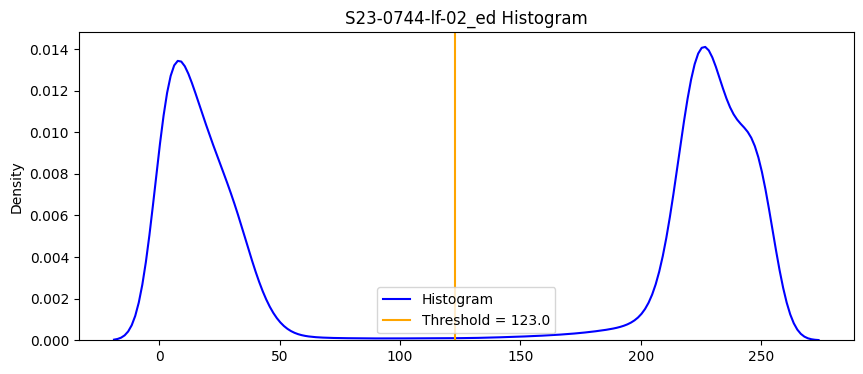

In [18]:
df_results = preprocess_leaf(image_paths_all[7: 8], resize_image = True, image_resolution_width = 1024, visualize_images = False, visualize_histogram = True)

S23-0744-lf-02_ed


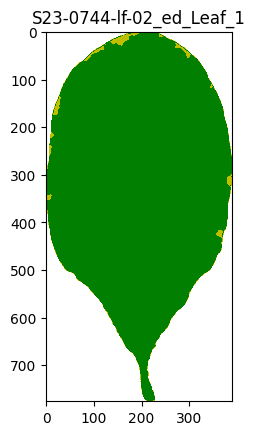

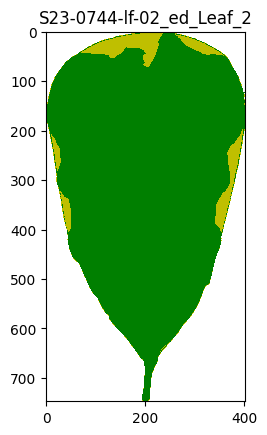

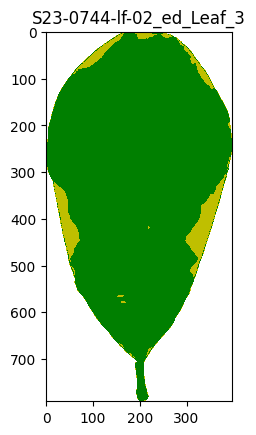

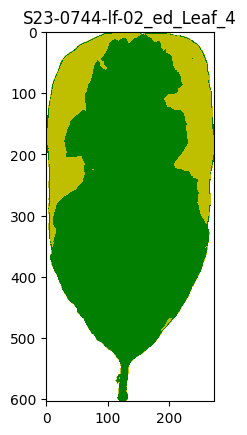

In [19]:
for i in range(8, len(image_paths_all)):
    df_results = preprocess_leaf(image_paths_all[i-1: i], threshold = 170, resize_image = True, image_resolution_width = 1024, visualize_images = True)
    break